# 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_score

# Your custom DBSCAN class here
from dbscan import DBSCAN


# 2. Test
First, we'll test the DBSCAN method we made on a synthetic moons dataset.

Silhouette Score: 0.33078776489960326


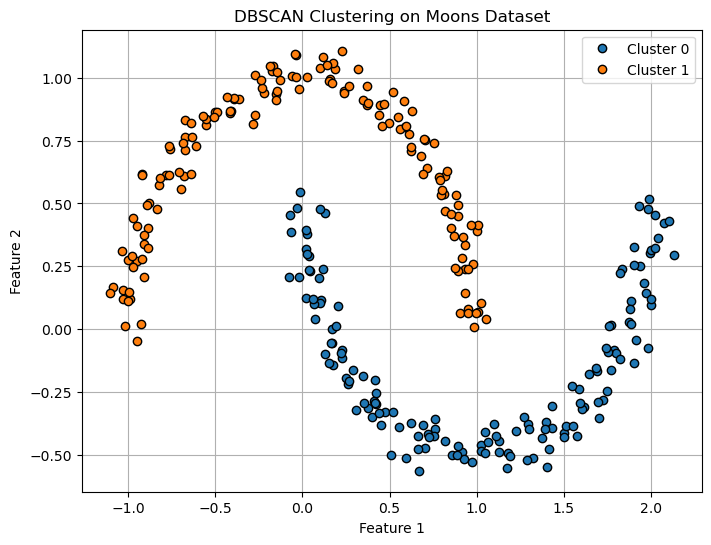

In [2]:

# Generate synthetic "moons" dataset
X, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# Apply custom DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X)

# Compute silhouette score if valid
if len(set(labels)) > 1 and -1 not in set(labels):
    score = silhouette_score(X, labels)
    print("Silhouette Score:", score)
else:
    print("Silhouette Score not defined (only one cluster or noise present).")

# Visualization
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.tab10(i) if i != -1 else (0, 0, 0) for i in unique_labels]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6, label=f"Cluster {k}")

plt.title("DBSCAN Clustering on Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


As we can see, it's done a pretty good job of capturing the shapes of the data, and separating out the two different clusters. Next, we'll see how it works on the same NFL passing dataset that we used for the KMeans clustering

# 3. NFL Passing Data

We'll run the same pre proccesing that we did in the K Means Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Career_Stats_Passing.csv")
# Remove rows with any missing values
df.dropna(inplace=True)

# Remove rows with any zeros in any column
df = df[(df != 0).all(axis=1)]

df["Passes Attempted"] = (
    df["Passes Attempted"]
    .str.replace(",", "")  # remove commas
    .astype(float)         # convert to float
)

# Optional: reset index after filtering
df.reset_index(drop=True, inplace=True)

                Player Id              Name Position  Year  \
0       tomsavage/2543640       Savage, Tom       QB  2016   
1       tomsavage/2543640       Savage, Tom       QB  2014   
2      connorcook/2555332      Cook, Connor       QB  2016   
3  jamisoncrowder/2552415  Crowder, Jamison       WR  2015   
4      phildawson/2500351      Dawson, Phil        K  2009   

                  Team  Games Played  Passes Attempted Passes Completed  \
0       Houston Texans             3              73.0               46   
1       Houston Texans             2              19.0               10   
2      Oakland Raiders             1              21.0               14   
3  Washington Redskins            16               1.0                0   
4     Cleveland Browns            11               1.0                1   

  Completion Percentage  Pass Attempts Per Game  ... TD Passes  \
0                  63.0                    24.3  ...         0   
1                  52.6                     

Player Id                          object
Name                               object
Position                           object
Year                                int64
Team                               object
Games Played                        int64
Passes Attempted                  float64
Passes Completed                   object
Completion Percentage              object
Pass Attempts Per Game            float64
Passing Yards                      object
Passing Yards Per Attempt          object
Passing Yards Per Game             object
TD Passes                          object
Percentage of TDs per Attempts     object
Ints                               object
Int Rate                           object
Longest Pass                       object
Passes Longer than 20 Yards        object
Passes Longer than 40 Yards        object
Sacks                              object
Sacked Yards Lost                  object
Passer Rating                     float64
dtype: object

In [13]:
df = df.loc[df.groupby("Name")["Passes Attempted"].idxmax()]

# Drop players in the bottom 5% of Passes_Attempted
threshold = np.percentile(df["Passes Attempted"], 5)
df_filtered = df[df["Passes Attempted"] > threshold].copy()

# Keep player info for final display
player_info = df_filtered[["Player ID", "Passes Attempted"]] if "Player" in df.columns else None

# Drop non-numeric and identifier columns for clustering
exclude_cols = ["Name", "Player_ID"] if "Name" in df.columns and "Player_ID" in df.columns else []
X = df_filtered.drop(columns=exclude_cols).select_dtypes(include=[np.number])

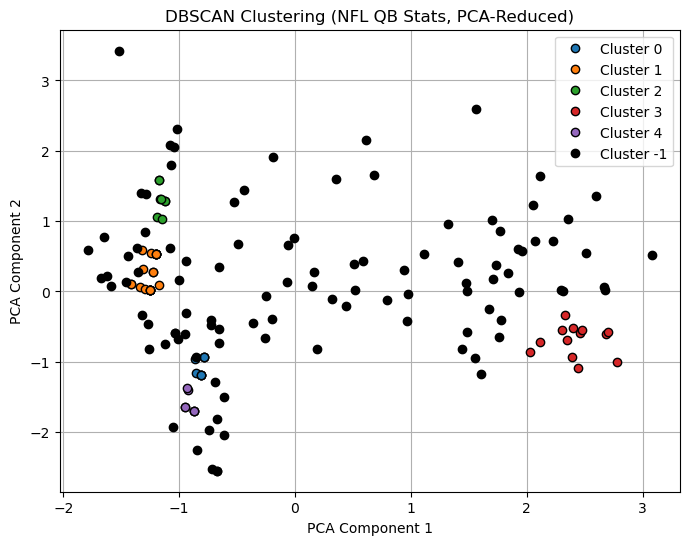

In [14]:
# Separate numerical columns for clustering
numeric_cols = df.select_dtypes(include="number").columns
X_numeric = df[numeric_cols]

# Scale only numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Run custom DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Visualization
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.tab10(i) if i != -1 else (0, 0, 0) for i in unique_labels]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X_pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6, label=f"Cluster {k}")

plt.title("DBSCAN Clustering (NFL QB Stats, PCA-Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

As we can see, the algorithm was also able to identify clusters, and even after PCA reduction, the clusters are still pretty close together. In addition, it identified a lot of players that were just noise, which is one of the big advantages of this method over K Means Clustering